# Project 2: Problem Representation
This project will help you familiarize with the standard data science toolkits: Numpy, Pandas for data processing and Matplotlib / Seaborn for visualization, with a focus on Numpy and Pandas. On a more conceptual level, we will be looking at how a data science problem can be represented in different ways and tackled from different perspectives.

You are encouraged to consult the NumPy documentation and Pandas documentation while working on this project. Both libraries offer many useful built-in functions that can speed up your code.

In [1]:
# import library modules
from collections import defaultdict, Counter
from scipy.sparse import csr_matrix, coo_matrix, csc_matrix

import sys
import argparse
import pandas as pd
import numpy as np
import scipy.sparse as sp
import scipy.linalg as la
import seaborn as sns

## Data-set Overview
We will be working with a movie rating dataset from the MovieLens web site (http://movielens.org). Specifically, we are going to use the **100K Dataset** which has 100,000 ratings from 943 users on 1682 movies.

Please visit the [README](http://files.grouplens.org/datasets/movielens/ml-100k-README.txt) webpage to get detailed descriptions about the files in the dataset -- their content and format.

For this project, we will use two files:
* `u.data`: contains the user_id, item_id, rating score and timestamp of each review.
* `u.item`: contains metadata about the movies.

These files can be found in the handout directory `ml-100k`.

Take a look at the online README to familiarize yourself with the format of the data in these files. **Note that the `item_id` column in `u.data` corresponds to the `movie_id` column in `u.item`**.

In [2]:
# load the user-ratings data 
ratings = pd.read_csv('ml-100k/u.data', sep='\t', names=['user_id', 'item_id', 'rating', 'timestamp'])

# load the movie metadata 
columns = ['movie_id', 'movie_title', 'release_date', 'video_release_date', 'IMDb_URL',
           'unknown', 'Action', 'Adventure', 'Animation', 'Children', 'Comedy',
           'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror',
           'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']

genres = columns[ columns.index('Action'):]
movies = pd.read_csv('ml-100k/u.item', sep='|', names=columns, index_col='movie_id', encoding="ISO-8859-1")

In [3]:
# note: this cell has been tagged with excluded_from_script.
# you do not need to remove it when submitting your notebook.
print("Ratings data")
display(ratings.head())

print("Movie data")
display(movies.head())

Ratings data


,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


Movie data


,movie_title,release_date,video_release_date,IMDb_URL,unknown,Action,Adventure,Animation,Children,Comedy,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
movie_id,,,,,,,,,,,,,,,,,,,,,
1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


**Note:** as you use Pandas to work with dataframes, keep in mind that most Pandas operations return a new dataframe instead of modifying the caller dataframe. To get the latter behavior, you can either reassign the caller dataframe to the return value of the function, or look for the option `inplace = True` while calling the function.


## Part A: Data Exploration and Visualization
---



### Question 1: Movie ratings by genre
Let's compare the average movie ratings by genre. Complete the function **`movie_rating_by_genre()`** which takes in the dataframes `movies` and `ratings`, along with the list `genres` of movie-genres. This function returns a dictionary where the key is a movie genre and the value is the average rating of the movies in that genre.
 
 
**Notes**:
* If a movie belongs to multiple genres, its rating(s) should be considered for each of those genres.
* If a movie is rated multiple times, **do not** compute the average rating per movie and then average rating per genre; you should gather all of the ratings in each genre and compute the average only once.

In [4]:
def movie_rating_by_genre(ratings, movies, genres):
    """
    Compute the average movie ratings by genres.

    args:
        ratings (pd.DataFrame)  : Dataframe containing user ratings
        movies (pd.DataFrame)   : Dataframe containing movie attributes
        genres (List[str]) :  the list of movie genres

    return:
        Dict[str, float]  : a mapping from movie genres to their average rating scores
    """
    merged_df = ratings.merge(movies, right_index = True, left_on = "item_id", how = "inner")
    genre_rating_dict = {}
    for genre in genres:
        genre_df = merged_df[merged_df[genre] == 1]
        genre_rating_dict[genre] = genre_df['rating'].mean()
    return genre_rating_dict

In [5]:
# local tests
def test_movie_rating_by_genre():
    genre_rating = movie_rating_by_genre(ratings, movies, genres)
    assert len(genre_rating) == 18
    assert np.allclose(genre_rating['Action'], 3.480245417953027)
    print("All tests passed!")

test_movie_rating_by_genre()

All tests passed!


Now that we have the average movie ratings by genre, let's plot them and see how they compare:

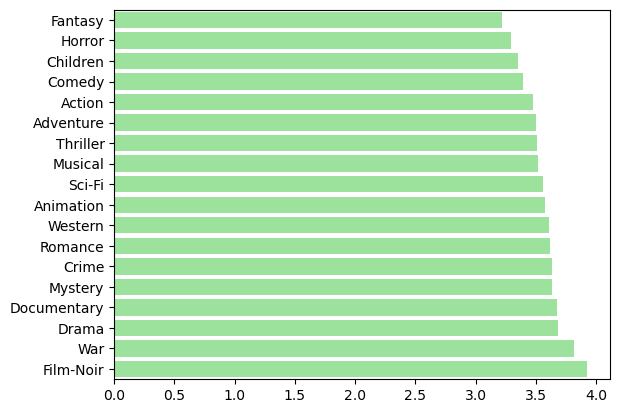

In [6]:
def plot_genre_rating(genre_rating):
    sorted_rating = sorted(genre_rating.items(), key= lambda kv: kv[1])
    xlist = [kv[1] for kv in sorted_rating]
    ylist = [kv[0] for kv in sorted_rating]
    ax = sns.barplot(x=xlist, y=ylist, orient='h', color='lightgreen')

plot_genre_rating(movie_rating_by_genre(ratings, movies, genres))

We see that *Film-Noir* genre has the highest average movie rating (about 3.9) while *Fantasy* genre has the lowest (about 3.2). Overall the average ratings are fairly balanced across different genres.

### Question 2: Movie count over time

Next, we will investigate how the number of movies released in each genre has evolved over the years. Complete the function `movie_count_by_genre` to return a nested dictionary having the following structure: 
```
{
    'Action': { 1922: 1, 1926: 2, ...},
    'Adventure': { 1922: 3, ...},
    ...
}
```
  
where the outer key is a genre, the inner key is a year and the value is the number of movies released for that genre in that year.

**Notes**:
1. The year can be retrieved from the last 4 characters in the release date. Movies which this extraction method does not work on can be ignored.
1. The year values (inner keys) in the returned dictionary (1922 and 1926 in the example above) are integers, not strings.
1. If a genre does not have any review in a certain year, that year should not be included in the inner dictionary.

In [7]:
def movie_count_by_genre(movies, genres):
    """
    Count the number of movies in each movie genre.

    args:
        movies (pd.DataFrame) : Dataframe containing movie attributes
        genres (List[str]) :  the list of movie genres

    return:
        Dict[str, Dict[int, int]]  : a nested mapping from movie genre to year to number of movies in that year
    """
    def get_year(release_date):
        try:
            return int(release_date.split('-')[2])
        except:
            return None

    movies['year'] = movies['release_date'].apply(lambda x: get_year(x))
 
    genre_dict = {}
    for genre in genres:
        genre_df = movies[movies[genre] == 1]
        year_count_list = genre_df.groupby('year').size()
        year_count_dict = {}
        for year, count in year_count_list.items():
            if count > 0:
                year_count_dict[year] = count
 
        genre_dict[genre] = year_count_dict
        
    return genre_dict

   

In [8]:
# local test
def test_movie_count_by_genre():
    genre_count = movie_count_by_genre(movies, genres)
    assert genre_count['Crime'][1997] == 30
    assert genre_count['Action'][1998] == 12
    assert genre_count['Drama'][1939] == 5
    print("All tests passed!")

test_movie_count_by_genre()

All tests passed!


Now let's try to plot the rating counts of a few genres and see how they change over time.

<Axes: xlabel='year', ylabel='movie_count'>

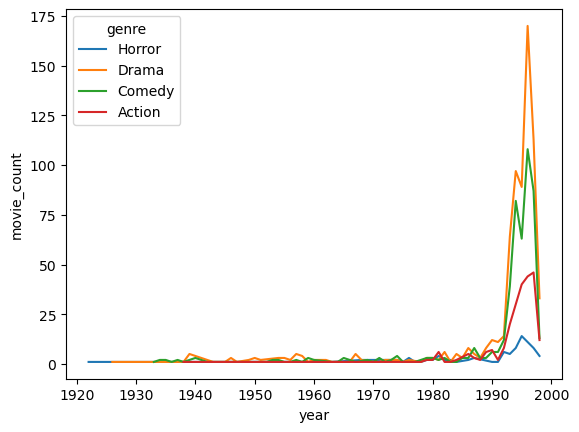

In [9]:
def plot_movie_count(selected_genres):
    genre_count = movie_count_by_genre(movies, genres)
    records = [
        (genre, year, movie_count)
        for genre, year_count in genre_count.items()
        for year, movie_count in year_count.items()
    ]
    movie_count_df = pd.DataFrame(records, columns=['genre', 'year', 'movie_count']).sort_values('year')
    movie_count_df = movie_count_df[movie_count_df["genre"].isin(selected_genres)]
    return sns.lineplot(x="year", y="movie_count", hue='genre', data=movie_count_df)
    
plot_movie_count(["Action", "Comedy", "Horror", "Drama"])

From the above graph, we see that, in terms of movie rating counts, the comedy and drama genre have become a lot more popular in the 1990s, compared to action or horror.

### Question 3: Movie ratings over time
The quantity of movie ratings has certainly increased over time, but is the quality of movies improving as well? We can plot the distribution of ratings in recent years to find out.

Complete the function `movie_rating_distribution` which returns a dataframe that contains the release year and rating from each user for each movie that **was released on or after** a particular year. The column names of this dataframe should be `release_year` and `rating`.

**Notes**: 
1. Ignore movies with invalid year values.
2. You need to return the release year and rating of movies. Since there might be multiple movies released in a year with the same rating, there can be duplicate entries in the dataframe.
3. Multiple ratings of the same movie by the same user should be considered unique, i.e., you do not have to perform any kind of aggregation in this question.
4. If the movies dataset has some movie IDs that are not present in the ratings dataset (i.e., movies without ratings), those movies should not be included in the returned dataframe.
6. The `rating` column in the returned dataframe should have type integer.

In [10]:
def movie_rating_distribution(movies, ratings, starting_year = 1990):
    """
    Record the release year and rating of every movie released on or after a starting year in the dataset.

    args:
        movies (pd.DataFrame)   : Dataframe containing movie attributes
        ratings (pd.DataFrame)  : Dataframe containing user ratings

    kwargs:
        starting_year (int) : the earliest release year for a movie to be considered

    return:
        pd.DataFrame  : a DataFrame of the movie release years and ratings
    """
    def get_year(release_date):
        try:
            return int(release_date.split('-')[2])
        except:
            return None
    movies_copy = movies.copy()
    ratings_copy = ratings.copy()
    
    movies_copy['release_year'] = movies_copy['release_date'].apply(lambda x: get_year(x))
    merged_df = ratings_copy.merge(movies_copy, right_index = True, left_on = "item_id", how = "inner")
    start_year_df = merged_df[merged_df['release_year'] >= starting_year]
    
    result = start_year_df[['release_year','rating']].copy()
    result['release_year'] = result['release_year'].astype(int)
    result['rating'] = result['rating'].astype(int)
    
    return result


In [11]:
# local test
def test_movie_rating_distribution():
    ratings_dist = movie_rating_distribution(movies, ratings)
    assert set(ratings_dist.columns) == set(["release_year", "rating"])
    assert ratings_dist.shape == (70445, 2)
    assert ratings_dist.release_year.shape == (70445,)
    assert len(ratings_dist[ratings_dist["release_year"] == 1995]) == 10499
    print("All tests passed!")

test_movie_rating_distribution()

All tests passed!


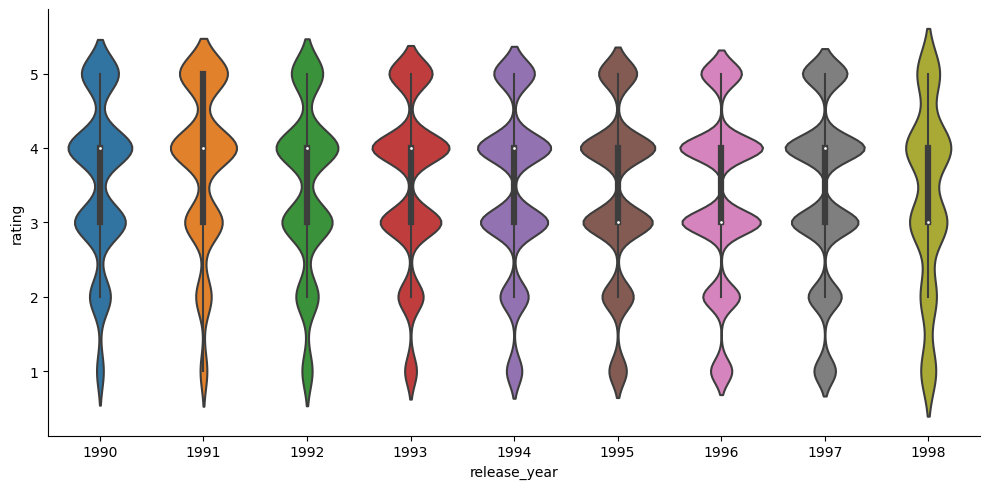

In [12]:
def plot_movie_rating_dist(ratings_dist):
    return sns.catplot(x = "release_year", y = "rating", data = ratings_dist, kind = "violin", height = 5, aspect = 2)
    
plot_movie_rating_dist(movie_rating_distribution(movies,ratings))

We see that most of the ratings concentrate between 3 and 4 in every year, although the median is 3 in some years (1995, 1996, 1998) and 4 in the rest. Furthermore, the ratings in 1998 seem to be most spread out.

### Question 4: Movie ratings by month

Now let's look at a specific year and see which month in that year has the most ratings. Complete the function `movies_reviewed_by_month` which returns a dataframe that contains the months of a year and the movie rating counts by month. This dataframe should have two columns: `month` and `rating_count`, where `month` is an integer from 1 to 12. Months that do not have any rating count should be excluded.

**Note**:
* The `timestamp` column in `ratings` is in unix time format (i.e., the number of seconds since 1970). You should identify the appropriate Pandas function to convert it to the standard datetime format. Try to use vectorization for speedup.

In [150]:
def movies_reviewed_by_month(ratings, year):
    """
    Count the number of ratings in each month of a given year.

    args:
        ratings (pd.DataFrame)  : Dataframe containing user ratings
        year (int)  : the year in which ratings are considered

    return:
        pd.DataFrame  : a DataFrame of the months and movie rating count in each month
    """
    
    ratings_copy = ratings.copy()
    ratings_copy['timestamp'] = pd.to_numeric(ratings_copy['timestamp'])  
    ratings_copy['date'] = pd.to_datetime(ratings_copy['timestamp'], unit='s')  
 
    ratings_copy['year'] = ratings_copy['date'].dt.year
    ratings_copy['month'] = ratings_copy['date'].dt.month
    
    monthly_ratings_df = (ratings_copy[ratings_copy['year'] == year].groupby("month", as_index=False)
                          .agg(rating_count=("month", "size")))
        
    return monthly_ratings_df


In [151]:
# local test
def test_movies_reviewed_by_month():
    ratings_by_month = movies_reviewed_by_month(ratings, 1997)
    assert list(ratings_by_month.loc[ratings_by_month['month']==9, 'rating_count'])[0] == 6704
    print("All tests passed!")

test_movies_reviewed_by_month()

All tests passed!


Now let's visualize the results:

<Axes: xlabel='month'>

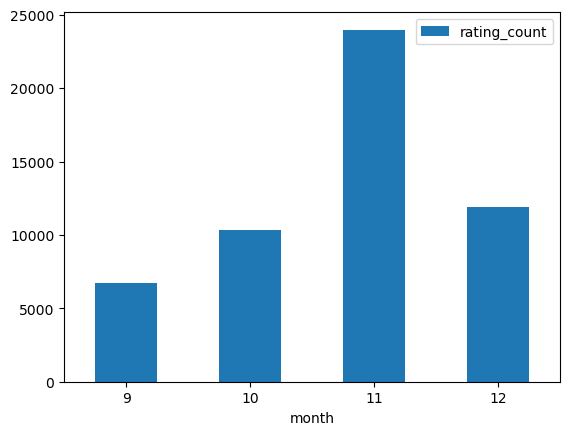

In [15]:
movies_reviewed_by_month(ratings, 1997).plot.bar(x='month', y='rating_count', rot=0)

It turns out that in 1997, November has the most ratings, almost twice as many as other months. What could be the reason for this?

### Question 5: Best and worst movies

Let's now look at which movies have the highest or lowest ratings. For simplicity, if a movie is rated multiple times, we consider the average of these ratings as the *rating score* for that movie. To ensure that the rating scores are robust, in this question we only consider movies that have more than 50 ratings.

Complete the function `best_worst_movies` which returns two lists -- one containing the movie ids of the movies with the highest average rating scores, and one with lowest average rating scores.

**Notes**:
1. The list for best movies should contain movies sorted in decreasing order of average rating
2. The list for worst movies should contain movies sorted in increasing order of average rating
3. Make sure you are using the threshold parameter correctly, as specified in the docstring.

In [142]:
def best_worst_movies(ratings, threshold = 50, size = 10):
    """
    Get the top movies with highest average ratings and top movies with lowest average ratings

    args:
        ratings (pd.DataFrame)  : Dataframe containing user ratings

    kwargs:
        threshold (int) : movies that are considered should have more ratings than this threshold
        size (int) : the number of movies with lowest / highest average ratings to get

    return: Tuple (best_movie_ids, worst_movie_ids)
            best_movie_ids (List[int])  : a list of ids for movies with the highest average ratings, sorted from highest to lowest average rating.
            worst_movie_ids [List[int]] : a list of ids for movies with the lowest average ratings, sorted from lowest to highest average rating.
    """
    movie_rating = ratings.groupby('item_id').agg(rating_count=('rating', 'size'),
                                                  average_rating=('rating', 'mean')).reset_index()
    movie_count = movie_rating[movie_rating['rating_count'] > threshold]
    
    if movie_count.empty:
        return [], []
    
    sorted_movie_count = movie_count.sort_values(by='average_rating',ascending=True)
    best_movie_ids = sorted_movie_count.tail(size).iloc[::-1]['item_id'].tolist()
    worst_movie_ids = sorted_movie_count.head(size)['item_id'].tolist()

    return best_movie_ids, worst_movie_ids



In [143]:
# local test
def test_best_worst_movies():
    best_movie_ids, worst_movie_ids = best_worst_movies(ratings)
    assert isinstance(best_movie_ids, list) and isinstance(worst_movie_ids, list)
    assert len(best_movie_ids) == len(worst_movie_ids) == 10
    assert best_movie_ids[0] == 408
    assert worst_movie_ids[0] == 931
    print("All tests passed!")

test_best_worst_movies()

All tests passed!


Now let's visualize the rating distribution for the best movie and the worst movie:

Best rated movie: Close Shave, A (1995)
Worst rated movie: Island of Dr. Moreau, The (1996)


<Axes: xlabel='item_id', ylabel='rating'>

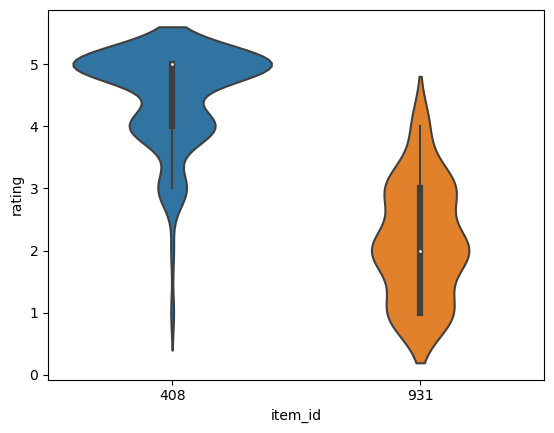

In [18]:
def plot_best_worst_rating_distribution(movies, ratings, best_movie_ids, worst_movie_ids):
    best_movie_id, worst_movie_id = best_movie_ids[0], worst_movie_ids[0]
    best_worst_ratings = ratings[ratings.item_id.isin([best_movie_id, worst_movie_id])]
    print(f'Best rated movie: {movies.loc[best_movie_id].movie_title}')
    print(f'Worst rated movie: {movies.loc[worst_movie_id].movie_title}')
    return sns.violinplot(x="item_id", y="rating", data=best_worst_ratings)
    
plot_best_worst_rating_distribution(movies, ratings, *best_worst_movies(ratings))

We see that there is a stark difference between the ratings for best movies (which are clustered around the top scores) and the ratings for worst movies (which are clustered around the bottom scores).

## Part B: Movie Recommendation Using Collaborative Filtering
---


In the primer, we studied how an unsupervised learning technique like  **collaborative filtering**  can be used to recommend new items to users based on their rating of other items as well as the item ratings by similar users.

Product recommendation is a major business avenue for many companies like Amazon, Netflix, IMDB, etc. Collaborative Filtering is the driving force behind this application. In this project, we will apply this algorithm to recommend new movies to users.

Most collaborative filtering algorithms fit into one of three categories:

*   User-user similarity approach
*   Item-item similarity approach
*   Matrix factorization approach

We will implement each of these techniques in this project. As a first step, in order to implement collaborative filtering, we first represent the data in a format suitable for the algorithm to work with, i.e., a format that enables easy manipulation and efficient computation within the algorithm framework.

If you get runtime error or get confused about the matrix dimensions, refer to the worked examples in the recommender system primer. Testing your code on these small examples is a good way to debug.

### Question 6: Data representation

We can represent the user ratings in a matrix $X \in \mathbb{R}^{ m \times n}$ for a dataset consisting of **m users** and **n movies** such that:
* $X_{ij}$ is the rating given by the `i`-th user to the `j`-th movie (note that the user/movie ids **may not** be consecutive integer values, so the `k`-th user/movie simply refers to the one with the `k`-th smallest id).
* If a user has not rated a movie, then the corresponding entry in the matrix should be 0.
* If a user has rated a movie several times, then we take the **maximum rating value**.

Complete the function `matrix_data` which takes in the `ratings` DataFrame and returns:
1. The user-movie rating matrix `X`
2. The mean user rating matrix `user_means`, which contains the average rating of every user.
3. The mean movie rating matrix `movie_means`, which contains the average rating for every movie.

As an example, the user-movie rating matrix `X` may look like `X = [[0,3], [0,1], [2,3]]` (where the 0 entries indicate that user 1 and 2 have not rated movie 1). The corresponding `user_means` is then `[3, 1, 2.5]` and the corresponding `movie_means` is `[2, 7/3]`.

**Notes**:
* The rating matrix `X` should have integer data type, not float.
* The mean user and movie ratings should be computed only over the observed (i.e., non-zero) entries.
* Refer to the Pandas primer to see how you may convert a dataframe from wide to long format or vice versa.


In [19]:
def matrix_data(ratings):
    """
    Represent the user-movie ratings data in a matrix format

    args:
        ratings (pd.DataFrame)  : raw ratings data represented in a pandas DataFrame

    return :
        Tuple[X, user_means, movie_means]
            X (np.array[num_users, num_movies]) : the actual ratings matrix
            user_means (np.array[num_users, ])  : mean user rating array over the observed ratings
            movie_means (np.array[num_movies, ])  : mean movie rating array over the obsevered ratings
    """
    ratings_matrix = ratings.pivot(index='user_id',columns='item_id',values='rating')
    ratings_matrix = ratings_matrix.fillna(0)
    X = ratings_matrix.to_numpy(dtype=int)
    
    X_float = X.astype(float)
    X_float[X_float == 0] = np.nan

    user_means = np.nanmean(X_float, axis=1)
    user_means = np.nan_to_num(user_means)
    
    movie_means = np.nanmean(X_float, axis=0)
    movie_means = np.nan_to_num(movie_means)

    return X, user_means, movie_means

    

In [20]:
# local test
def test_matrix_data():
    X, user_means, movie_means = matrix_data(ratings)
    assert X.shape == (943, 1682)
    assert X.dtype == np.int64
    assert user_means.shape == (943,)
    assert movie_means.shape == (1682,)
    assert np.array_equal(X[5,:10], np.array([4, 0, 0, 0, 0, 0, 2, 4, 4, 0]))
    assert np.allclose(movie_means[0], 3.8783185840707963)
    assert np.allclose(user_means[0], 3.610294117647059)
    print("All tests passed!")

test_matrix_data()

All tests passed!


Our next step is to get the similarity weights. Let's go ahead and implement the cosine similarity function:

### Question 7: Cosine similarity

The Cosine similarity between *user i* and *user k* is the weight

$$W_{ik}=\frac{\sum_{j = 1}^{n}X_{ij} X_{kj}}{\sqrt{\sum_{j = 1}^{n}{X_{ij}}^2}\sqrt{\sum_{j = 1}^{n}{X_{kj}}^2}}.$$

Complete the `cosine_similarity` function which takes in ratings matrix `X` and returns the user-user similarity matrix `W` using cosine similarity.

**Note**:
* Avoid using for loops. `np.outer` may be helpful here.
* Refer to the [Recommender System primer](https://nbviewer.jupyter.org/url/clouddatascience.blob.core.windows.net/primers/recommender-system-primer/recommender_system_primer.ipynb) for an example of this computation.

In [21]:
def cosine_similarity(X):
    """
        Compute the user-user cosine-similarity matrix.

    args: 
        X (np.array[num_users, num_movies]) : the user-movie rating matrix

    return:
        np.array[num_users, num_users]  : the cosine-similarity matrix
    """
    numerator = np.dot(X, X.T)
    
    X_sqrt = np.sqrt(np.sum(X ** 2, axis=1)) 
    X_sqrt_T = np.sqrt(np.sum(X.T ** 2, axis=0)) 
       
    denominator = np.outer(X_sqrt,X_sqrt_T)

    cosine_similarity_matrix = numerator / denominator
    
    return cosine_similarity_matrix


In [22]:
# local test
def test_cosine_similarity():
    X = np.array([[0, 3], [0, 1], [2, 3]])
    W_user_cosine = cosine_similarity(X)
    assert W_user_cosine.shape == (3, 3)
    assert np.allclose(W_user_cosine[0, 2], 0.8320502943378437)

    X = matrix_data(ratings)[0]
    W_user_cosine = cosine_similarity(X)
    assert W_user_cosine.shape == (943, 943)
    assert np.allclose(W_user_cosine[20, 37], 0.16907916618206115)
    assert np.allclose(W_user_cosine[100, 101], 0.1537501042084208)
    print("All tests passed!")

test_cosine_similarity()

All tests passed!


### Question 8a: Predict user ratings based on user-user similarity
We are now ready to make predictions about the missing ratings:

$$\hat X_{ij} = \bar x_i + \frac{  \sum_{k=1}^m \mathbb{1}(X_{kj} \ne 0) \cdot w_{ik}(X_{kj} - \bar x_k)}{ \epsilon + \sum_{k=1}^m \mathbb{1}(X_{kj} \ne 0) \cdot |w_{ik}|}$$

Note that we add a smoothing constant $\epsilon$ in the denominator to cover the case where no user has previously rated the movie $j$. Complete the `predict_user_user` function which takes as input the rating matrix `X`, user-user similarity matrix `W` and `user_means` array; it then returns the rating prediction matrix $\hat{X}$.

**Notes**:
* To handle conditional sum, we can multiply our input matrix with some binary indicator matrix. Which binary matrix is suitable here?
* Recall that you can add a vector to every column of a matrix by broadcasting that vector to 2D.

In [23]:
def predict_user_user(X, W, user_means, eps=1e-12):
    """
    Using the user-user similarity matrix, return the predicted ratings matrix

    args: 
        X (np.array[num_users, num_movies]) : the actual ratings matrix, where missing entries are 0
        W (np.array[num_users, num_users])  : user-user similarity weight matrix
        user_means (np.array[num_users, ])  : mean-user-rating array
        user_id (int)  : the id of the user whose missing ratings are predicted (from 0 to num_user)
        eps (float) : smoothing constant to avoid division by zero

    return:
        np.array[num_users,  num_movies] -- the predicted ratings matrix
    """
    binary_matrix = np.where(X == 0, 0, 1) 
    
    user_means_broadcasted = user_means[:, None]
    
    subtract_matrix = (X - user_means_broadcasted) * binary_matrix
    numerator = np.dot(W, subtract_matrix)

    denominator = eps + np.dot(np.abs(W), binary_matrix)
    
    predicted_ratings_matrix = user_means_broadcasted + (numerator / denominator)
    
    return predicted_ratings_matrix

In [24]:
def test_predict_user_user():
    X = np.array([[0, 3], [0, 1], [2, 3]])
    user_means = np.array([3, 1, 2.5])
    W_user_cosine = cosine_similarity(X)
    X_predicted = predict_user_user(X, W_user_cosine, user_means)
    assert X_predicted.shape == X.shape
    assert np.allclose(X_predicted, [[2.5, 3.14689893], [0.5, 1.14689893], [2, 2.6876806]])
    print("All tests passed!")

test_predict_user_user()

All tests passed!


### Question 8b: Evaluate the prediction
To see how good our predictions $\hat X_{ij}$'s are, we can compare them with the observed ratings. Complete the function `mean_rating_diff` that computes the difference value

$$\frac{\sum_{i=1}^m \sum_{j=1}^n \mathbb{1}(X_{ij} \ne 0) \cdot (X_{ij} - \hat X_{ij})^2}{\sum_{i=1}^m \sum_{j=1}^n \mathbb{1}(X_{ij} \ne 0)},$$

where the denominator is the number of non-zero entries in $X$.

Note:

* Make sure your output is a NumPy float (with data type np.float64) instead of a regular Python float, to prevent errors.

In [25]:
def mean_rating_diff(X_true, X_pred):
    """
    Return the mean squared difference between the predicted and the actual ratings matrix.
    
    args: 
        X_true (np.array[num_users, num_movies]) : the actual ratings matrix, where missing entries are 0
        X_pred (np.array[num_users, num_movies]) : the predicted ratings matrix

    return
        np.float64 : mean squared difference between the predicted and the actual ratings matrix
    """
    binary_matrix = np.where(X_true == 0, 0, 1) 
    
    mean_sq = binary_matrix * ((X_true - X_pred)**2)
    
    numerator = np.sum(mean_sq)
    denominator = np.sum(binary_matrix)
     
    mean_squared_difference = numerator / denominator
  
    return mean_squared_difference

In [26]:
# local test
def test_mean_rating_diff():
    X = np.array([[0, 3], [0, 1], [2, 3]])
    user_means = np.array([3, 1, 2.5])
    W_user_cosine = cosine_similarity(X)
    X_pred = predict_user_user(X, W_user_cosine, user_means)
    diff = mean_rating_diff(X, X_pred)
    assert isinstance(diff, np.float64), type(diff)
    assert np.allclose(diff, 0.035175498983549575)

    X, user_means, _ = matrix_data(ratings)
    W_user_cosine = cosine_similarity(X)
    X_pred = predict_user_user(X, W_user_cosine, user_means)
    diff = mean_rating_diff(X, X_pred)
    assert isinstance(diff, np.float64)
    assert np.allclose(diff, 0.7992514466097069)
    
    print("All tests passed!")

test_mean_rating_diff()

All tests passed!


### Question 9: Predict user ratings based on item-item similarity
The math for item-item collaborative filtering approaches is essentially identical to the user-user case, just with the matrices transposed. To predict the likely rating for user $i$ and item $j$, we form a weighted combination of the other item ratings that user $i$ has rated, weighted by the similarity between the two items $i$ and $j$:
$$\hat X_{ij} = \bar x_j + \frac{ \sum_{k=1}^n \mathbb{1}(X_{ik} \ne 0) \cdot w_{jk}(X_{ik} - \bar x_k)}{ \epsilon + \sum_{k=1}^n \mathbb{1}(X_{ik} \ne 0) \cdot |w_{jk}|},$$

where $k$ iterates over all the items. One nice feature of this approach is that we can reuse the functions in the user-user approach as before, in addition to transposing the relevant matrices. 

Complete the function `predict_item_item` which takes as input the rating matrix `X`, item-item similarity matrix `W` and `item_means` array. It then returns the ratings prediction matrix $\hat{X}$.

In [28]:
def predict_item_item(X, W, item_means, eps=1e-12):
    """
    Using the item-item similarity matrix, return the predicted ratings matrix.
    
    args: 
        X (np.array[num_users, num_movies]) : the actual ratings matrix
        W (np.array[num_movies, num_movies]) : movie-movie similarity weight matrix
        item_means (np.array[num_movies, ]) : mean-movie-rating array
        eps (float) : smoothing constant to avoid division by zero

    return:
        np.array[num_users, num_movies] : the predicted ratings matrix
    """
    predicted_ratings_matrix = predict_user_user(X.T, W, item_means, eps)
    return predicted_ratings_matrix.T

In [29]:
# local test
def test_predict_item_item():
    X = np.array([[0, 3], [0, 1], [2, 3]])
    item_means = np.array([2, 7/3])
    W_item_cosine = cosine_similarity(X.T)
    X_predicted = predict_item_item(X, W_item_cosine, item_means)
    assert X_predicted.shape == X.shape
    assert np.allclose(X_predicted, [[2.66666667, 3], [0.66666667, 1], [2.27177979, 2.72822021]])
    print("All tests passed!")

test_predict_item_item()

All tests passed!


## Sparse Representation:
Until now, we have been working with a ratings matrix $X$ with shape $943\times1682$. In practical recommender systems, the data size is usually much larger where our *dense matrix* approach will overburden the system both in computation and storage.

Therefore, we have to identify a more efficient data representation to tackle this problem. One solution is to use **sparse matrices**. We notice that most entries in the ratings matrix are 0 because every user only rates a very small subset of all movies. We can leverage this observation to only store the non-zero entries of the matrix in a form known as "sparse" form, which is supported by the `scipy.sparse` library.


### Question 10: Running Matrix Factorization

We start by implementing the alternating least square (ALS) algorithm for matrix factorization:
1. Initialize $U \in \mathbb{R}^{m \times k}$ and $V \in \mathbb{R}^{k \times n}$ with values distributed normally. Here $m$ is the number of users, $n$ is the number of movies, and $k$ is the input number of features.
2. Repeat `n_iters` times:
    * Update the columns of $V$:
    $$v_{j} := \left(\lambda I + \sum_{X_{ij} \ne 0} u_i u_i^T \right)^{-1} \left( \sum_{X_{ij} \ne 0} u_i X_{ij} \right), \quad j = 1, \ldots, n$$
    * Update the rows of $U$:
    $$u_{i} := \left(\lambda I + \sum_{X_{ij} \ne 0} v_j v_j^T \right)^{-1} \left( \sum_{X_{ij} \ne 0} v_j^T X_{ij} \right), \quad i = 1, \ldots, m$$

**Notes**:
* You should initialize $U$ and $V$ with `np.random.normal` where `loc = 0` and `scale = 0.1` ($U$ is initialized before $V$).
* The notation $\sum_{X_{ij} \ne 0} u_i u_i^T$ is shorthand for $\sum_{i=1}^m \mathbb{1}(X_{ij} \ne 0) \times u_i u_i^T$. Recall from the primer that to implement this conditional sum, you can use either a binary matrix or NumPy indexing.
* To avoid singularity issues with inverting matrices, when computing $A^{-1}B$ you should use `la.solve(A + lam * I, B)`, where `I` is the identity matrix with the same shape as `A` and `lam` is the smoothing parameter.
* For simplicity, you **are allowed to** update each row $v_j$ and each column $u_i$ individually, i.e., you don't need to derive a matrix formula that yields the entire new $U$ or $V$ at once (though you should still use matrix operations to compute the $u_i$'s and $v_j$'s). To be consistent with the autograder, make sure to **update $v_j$ before $u_i$** in each operation.
* This is the most difficult question. Take your time to think through it. Use examples with small numbers to debug your code (see the [Recommender System primer](https://nbviewer.jupyter.org/url/clouddatascience.blob.core.windows.net/primers/recommender-system-primer/recommender_system_primer.ipynb)). Make sure that every function call returns what you expect it to; for example, getting a row or column from a sparse matrix will always return a **2D matrix instead of 1D vector**, so make sure to apply the appropriate conversion (see the sparse matrix section in the [Numpy primer](https://nbviewer.jupyter.org/url/clouddatascience.blob.core.windows.net/primers/numpy-primer/numpy_primer.ipynb)).
* In the sum $\sum_{X_{ij} \ne 0} u_i X_{ij}$, the $u_i$’s should be treated as column vectors, so the sum would yield a $k×1$ vector. See the worked example in the recommender system primer for more details.

In [135]:
def low_rank_matrix_factorization(X_sparse, k, niters=5, lam=10., seed = 0):
    """
    Factor a rating matrix into user-features and movie-features.

    args: 
        X_sparse (sp.coo_matrix[num_users, num_movies]) : the ratings matrix, assumed sparse in COO format
        k (int) : the number of features in the lower-rank matrices U and V
        niters (int) : number of iterations to run
        lam (float) : regularization parameter, shown as lambda
        seed (int) : the seed for numpy random generator

    return : Tuple(U, V)
        U : np.array[num_users,  k] -- the user-feature matrix
        V : np.array[k, num_movies] -- the movie-feature matrix
    """
    # do not modify this line
    np.random.seed(seed)

    m,n = X_sparse.shape
    U = np.random.normal(loc=0, scale=0.1, size=(m,k))
    V = np.random.normal(loc=0, scale=0.1, size=(k,n))
    X_sparse_csr = X_sparse.tocsr()
    binary_matrix = np.where(X_sparse_csr.toarray() == 0, 0, 1)
    I = np.eye(k)

    for iters in range(niters):
        #for V
        for j in range(n):
            non_zero_values = binary_matrix[:,j] == 1
            u_matrix = U[non_zero_values, :]
            x_matrix = X_sparse_csr[non_zero_values,j].toarray().flatten()
            
            A = np.dot(u_matrix.T, u_matrix)
            B = np.dot(x_matrix, u_matrix)
            
            V[:,j] = la.solve(A + lam * I, B)
        
        #for U
        for i in range(m):
            non_zero_values = binary_matrix[i,:] == 1
            v_matrix = V[:,non_zero_values]
            x_matrix = X_sparse_csr[i, non_zero_values].toarray().flatten()
            
            A = np.dot(v_matrix, v_matrix.T)
            B = np.dot(x_matrix, v_matrix.T)
            
            U[i,:] = la.solve(A + lam * I, B)
            
    return U, V


In [136]:
# local test
def test_low_rank_matrix_factorization():
    X_check = sp.coo_matrix([[5., 0., 0.], [1., 1., 0.]])
    U_check, V_check = low_rank_matrix_factorization(X_check, 3)
    assert np.allclose([
        [2.52975137e-04, 8.88862671e-05, 8.88927380e-05],
        [5.26156164e-05, 1.84872240e-05, 1.84885459e-05],
    ], U_check), U_check
    assert np.allclose([
        [5.05950291e-04, 1.77772540e-04, 1.77785482e-04],
        [2.02058899e-05, 7.09970620e-06, 7.09998333e-06],
        [0, 0, 0]
    ], V_check.T), V_check.T
    print("All tests passed!")

test_low_rank_matrix_factorization()

All tests passed!


### Question 11: Make recommendations

With $U$ and $V$, we can now compute the predicted ratings $\hat X = UV$. For each user $u_i$, let's recommend the movie with the highest predicted rating that the user has not rated before:

$$r_i = 1 + \underset{j}{\operatorname{argmax}} \left(\mathbb{1}(X_{ij} = 0) \times \hat X_{ij} \right).$$

Implement the function `recommend` that returns a list of recommended movie ids, one for each user.

**Note**:
* The actual movie ids are numbered starting at 1 and not 0 in the original `ratings` dataframe. In other words, if you recommend a movie at column index $j$ in $X$, its movie id is $j+1$. This is why there is a 1 added to the argmax above.

In [137]:
def recommend_mf(X_sparse, U, V):
    """
    Recommend a new movie for every user.

    args:
        X_sparse (sp.coo_matrix[num_users, num_movies]) : the ratings matrix
        U (np.array[num_users, num_features]) : a matrix of features for each user
        V (np.array[num_features, num_movies]) : a matrix of features for each movie

    return:
        List[int] -- a list of ids of recommended movie, one for each user
    """
    recommended_index = []
    
    predicted_ratings = np.dot(U,V)
    X_sparse_csr = X_sparse.tocsr()
    binary_matrix = np.where(X_sparse_csr.toarray() == 0, 1, 0)

    predicted_matrix = binary_matrix * predicted_ratings

    recommended_index = np.argmax(predicted_matrix, axis=1)
    recommended_index = [index + 1 for index in recommended_index.tolist()]

    return recommended_index

In [138]:
# local test
def test_recommend_mf():
    U = np.array([[1., 1., 0., 0.], [0., 1., 0., 1.]])
    V = np.array([[.5, 0., 0., .5], [0., .5, .5, 0.], [.5, -1., .5, 3.]]).T
    X = sp.coo_matrix([[5., 0., 0.], [1., 1., 0.]])
    recommendation = recommend_mf(X, U, V)
    assert recommendation == [2, 3]
    print("All tests passed!")

test_recommend_mf()

All tests passed!


Now let's bring everything together: we will compute the predicted ratings matrix using the three approaches implemented above, evaluate their mean squared differences to the observed ratings, and see how the recommendations differ across these approaches. You have implemented all the pieces, so there is no more work on your part! Simply run the code below to see the results. What do you observe about the mean squared rating errors of the three approaches? What about the most frequently recommended movies in each approach?

In [139]:
# this cell has been tagged with excluded_from_script
# it will not be run by the autograder
from collections import Counter

def recommend_user_user_item_item(X, X_pred, size = 10):
    X_hat_remove_observed = np.where(X != 0, -np.inf, X_pred)
    return (X_hat_remove_observed.argmax(axis = 1) + 1).tolist()

def most_recommended_movies(recommended_movie_ids, size = 10):
    counts = Counter(recommended_movie_ids)
    return [(movies.loc[m_id].movie_title, count) for m_id, count in counts.most_common(size)]

def compare_cf_approaches():
    X, user_means, item_means = matrix_data(ratings)
    
    # user-user approach
    W_user_cosine = cosine_similarity(X)
    X_pred_user_user = predict_user_user(X, W_user_cosine, user_means)
    print("The mean squared error of the predicted ratings in the user-user approach is", mean_rating_diff(X, X_pred_user_user))
    print("The top 10 most frequently recommended movies in the user-user approach is")
    print(most_recommended_movies(recommend_user_user_item_item(X, X_pred_user_user)))
    
    # item-item approach
    W_item_cosine = cosine_similarity(X.T)
    X_pred_item_item = predict_item_item(X, W_item_cosine, item_means)
    print("The mean squared error of the predicted ratings in the item-item approach is", mean_rating_diff(X, X_pred_item_item))
    print("The top 10 most frequently recommended movies in the user-user approach is")
    print(most_recommended_movies(recommend_user_user_item_item(X, X_pred_item_item)))
    
    # matrix-factorization approach
    X_sparse = sp.coo_matrix(X)
    U, V = low_rank_matrix_factorization(X_sparse, 10, 15)
    X_pred_mf = U @ V
    print("The mean squared error of the predicted ratings in the matrix factorization approach is", mean_rating_diff(X, X_pred_mf))
    print("The top 10 most frequently recommended movies in the user-user approach is")
    print(most_recommended_movies(recommend_mf(X_sparse, U, V)))

compare_cf_approaches()

The mean squared error of the predicted ratings in the user-user approach is 0.7992514466097069
The top 10 most frequently recommended movies in the user-user approach is
[('Great Day in Harlem, A (1994)', 942), ('Aiqing wansui (1994)', 1)]
The mean squared error of the predicted ratings in the item-item approach is 0.762922908097654
The top 10 most frequently recommended movies in the user-user approach is
[('Entertaining Angels: The Dorothy Day Story (1996)', 217), ('Star Kid (1997)', 194), ('Aiqing wansui (1994)', 126), ('They Made Me a Criminal (1939)', 108), ("Someone Else's America (1995)", 91), ('Santa with Muscles (1996)', 58), ('Marlene Dietrich: Shadow and Light (1996) ', 48), ('Saint of Fort Washington, The (1993)', 46), ('Prefontaine (1997)', 24), ('Great Day in Harlem, A (1994)', 18)]
The mean squared error of the predicted ratings in the matrix factorization approach is 0.644387432702959
The top 10 most frequently recommended movies in the user-user approach is
[('Titanic